In [2]:
import numpy as np
import torch
import scipy.signal as sp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchaudio.functional import convolve
from IPython.display import Audio
from fb_utils import fir_tightener3000, fir_tightener4000, frame_bounds_lp, random_filterbank

In [3]:
with open('audfreqz.npy', 'rb') as f:
    gf = np.load(f)

In [4]:
import librosa
speech_full = librosa.load('speech.wav')
speech_full = librosa.resample(speech_full[0],orig_sr=22050,target_sr=16000)
len = 10000
speech = speech_full[1500:1500+len].reshape(1,-1)

x = torch.randn(32,1,len)
x[0,0,:] = torch.tensor(speech / np.linalg.norm(speech), dtype=torch.float32)

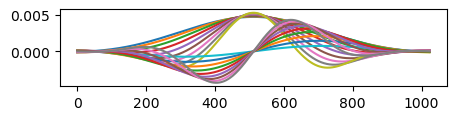

In [7]:
# Audlet style filterbank
supp = 1024
g = np.fft.ifft(gf, axis=0)
g = np.roll(g, supp//2, axis=0)
g_re = np.real(g[:supp]).T
g_im = np.imag(g[:supp]).T
g_c = g_re + 1j*g_im
g_re_tensor = torch.tensor(g_re, dtype=torch.float32).unsqueeze(1)
g_im_tensor = torch.tensor(g_im, dtype=torch.float32).unsqueeze(1)
# g_c_tensor = torch.tensor(g_c, dtype=torch.complex64).unsqueeze(1)

num = np.arange(1,10)
plt.figure(figsize=(5,1))
plt.plot(g_re[num,:].T)
plt.plot(g_im[num,:].T)
plt.show()

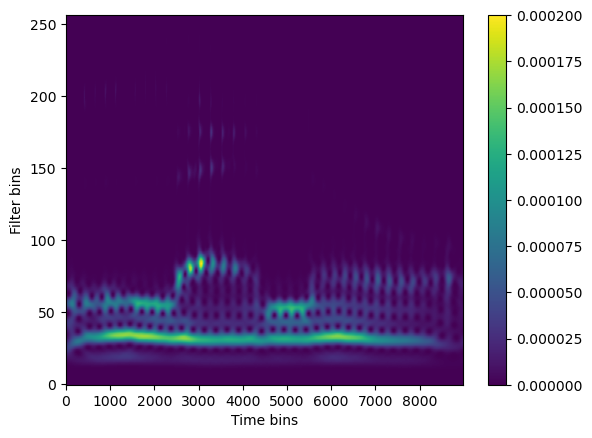

In [9]:
x_enc_re = F.conv1d(x, g_re_tensor, stride=1, padding=0)
x_enc_im = F.conv1d(x, g_im_tensor, stride=1, padding=0)
x_enc_mag = x_enc_re**2 + x_enc_im**2

plt.imshow(x_enc_mag.numpy()[0,:,:], vmin=0, vmax=0.0002, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_tilde_re = F.conv_transpose1d(x_enc_re, g_re_tensor, stride=1, padding=0).squeeze(0)
x_tilde_im = F.conv_transpose1d(x_enc_im, g_im_tensor, stride=1, padding=0).squeeze(0)
x_tilde = x_tilde_re + x_tilde_im

In [154]:
Audio(data=x_tilde.numpy(), rate=16000)

In [15]:
g_re_tight = fir_tightener3000(g_re, 1024)
g_im_tight = fir_tightener3000(g_im, 1024)
g_tight = g_re_tight + 1j*g_im_tight
g_re_tight_tensor = torch.tensor(g_re_tight, dtype=torch.float32).unsqueeze(1)
g_im_tight_tensor = torch.tensor(g_im_tight, dtype=torch.float32).unsqueeze(1)

In [17]:
with open('aud_1024_re.npy', 'wb') as f:
    np.save(f, g_re_tight)

with open('aud_1024_im.npy', 'wb') as f:
    np.save(f, g_im_tight)

with open('aud_1024.npy', 'wb') as f:
    np.save(f, g_tight)

In [11]:
# random filterbank
supp_ran = 16
W_random = random_filterbank(supp_ran, 257, supp_ran, norm=True, tight=False, to_torch=False, support_only=True)
W_random = fir_tightener3000(W_random, supp_ran)
W_random_tensor = torch.tensor(W_random, dtype=torch.float32).unsqueeze(1)

In [12]:
stride = 16
stride_ran = 1

x_enc_re = F.conv1d(x, g_re_tight_tensor, stride=stride)
x_enc_im = F.conv1d(x, g_im_tight_tensor, stride=stride)

x_enc_re_both = F.conv1d(x_enc_re, W_random_tensor, stride=stride_ran, groups=257).squeeze(0)
x_enc_im_both = F.conv1d(x_enc_im, W_random_tensor, stride=stride_ran, groups=257).squeeze(0)

x_tilde_re = F.conv_transpose1d(x_enc_re, g_re_tight_tensor, stride=stride).squeeze(0)
x_tilde_im = F.conv_transpose1d(x_enc_im, g_im_tight_tensor, stride=stride).squeeze(0)

In [ ]:
torch.tensor(1+1j, dtype=torch.complex64) 

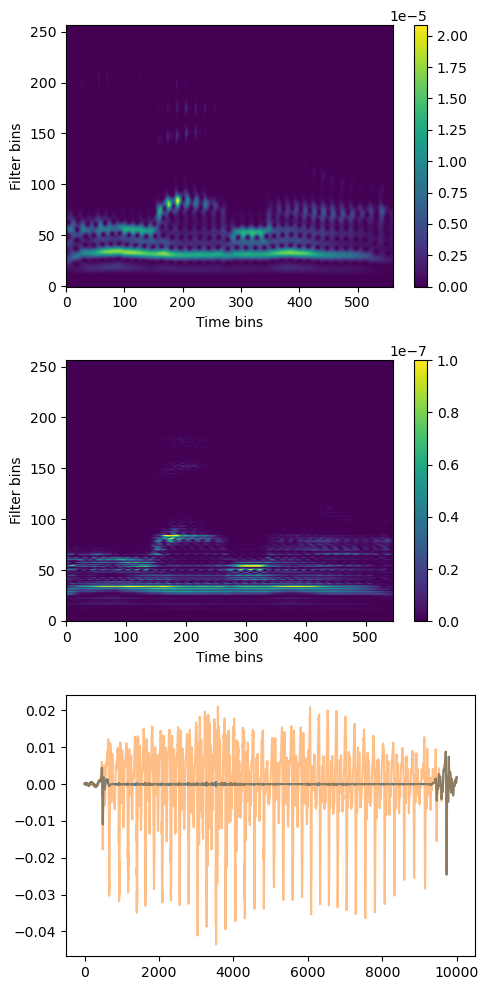

In [14]:
# magnitude response
x_enc_mag = x_enc_re**2 + x_enc_im**2

x_enc_mag_both = x_enc_re_both**2 + x_enc_im_both**2

# reconstruction
x_tilde = (x_tilde_re + x_tilde_im)/2*stride

# figure size
plt.figure(figsize=(5,10))

plt.subplot(3,1,1)
plt.imshow(x_enc_mag.numpy()[0,:,:], vmin=0, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

plt.subplot(3,1,2)
plt.imshow(x_enc_mag_both.numpy()[0,:,:], vmin=0, vmax=0.0000001, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

plt.subplot(3,1,3)
plt.plot(x[0,:,:].T-x_tilde[0,:,:].T)
plt.plot(x[0,:,:].T, alpha=0.5)

plt.tight_layout()
plt.show()

In [182]:
Audio(data=x_tilde.numpy(), rate=16000)